# SBI example for coverage tests - MultiPIT vs. HPD and WALDO

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.close("all")

import torch

from sbi.utils import BoxUniform
from torch.distributions.multivariate_normal import MultivariateNormal

import sys
sys.path.append('../../valDiags_flows/')

from data.data_generators import SBIGaussian2d
from data.feature_transforms import identity, first_dim_only
from plot import plot_2d_pdf_on_grid, plot_2d_pdf_contours

from nde.flows import construct_maf
from nde.train import train

from diagnostics.pp_plots import multi_cde_pit_values, PP_plot_1D
from diagnostics.localPIT_regression import localPIT_regression_baseline
from diagnostics.quantile_regression import train_qr_algo
from diagnostics.confidence_regions import (
    hpd_region,
    waldo_confidence_region,
    waldo_stats,
)
from diagnostics.hpd_coverage import highest_density

from tqdm import tqdm
import os


In [2]:
B = 100_000
B_PRIME = 10000
B_DOUBLE_PRIME = 10000
N_SAMPLES_POSTERIOR = 50000

PATH_EXPERIMENT = "../saved_experiments/SBIGaussian2d/"

CONFIDENCE_LEVEL = 0.95


## SBI Task: Simulator, Prior and True/Target Posterior 

- Prior (2D): $p(\theta) = \mathcal{U}([-10,10]^2)$
- Simualtor (2D): $x \sim \text{Simulator}(\theta) \approx p(x\mid \theta) = \mathcal{N}(\theta, \Sigma)$ with $\Sigma = \begin{pmatrix} 1 & 0.8 \\ 0.8 & 1 \end{pmatrix}$

Goal: estimate $p(\theta\mid x_0)$ with $x_0$ an observation.

In [3]:
# SBI Task: Inference of 2d Gaussian Mean under uniform prior

# Prior
low_, high_ = -10, 10
prior = BoxUniform(
    low=torch.FloatTensor([low_, low_]), high=torch.FloatTensor([high_, high_])
)

# Data Generator
data_gen = SBIGaussian2d(prior=prior)

# Simulator
simulator = data_gen.simulator

In [4]:
# Observation
filename = PATH_EXPERIMENT + "groundtruth_observation.pkl"
if os.path.exists(filename):
    observation = torch.load(filename)
    theta_true, x_obs = observation["theta_true"], observation["x_obs"]
else:
    theta_true = torch.FloatTensor([1, 1])  # true parameters
    x_obs = simulator(theta_true)  # x_0 ~ simulator(theta_true)
    observation = {"theta_true": theta_true, "x_obs": x_obs}
    torch.save(observation, "groundtruth_observation.pkl")

# True posterior: P(theta|x_0)
true_posterior_pdf = data_gen.true_posterior_pdf(x_obs)


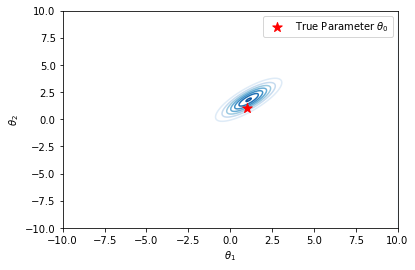

In [107]:
# Plot P(theta|x_0), x_0 ~ simulator(theta_true)
plt.scatter(theta_true[0], theta_true[1], marker="*", color="red", s=100, zorder=1, label=r'True Parameter $\theta_0$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plot_2d_pdf_on_grid(true_posterior_pdf, low_, high_)
plt.legend()
plt.show()


The simulator is stochastic, meaning that a generated observation `x_obs` might not correspond to the most probable one. In this case, the posterior $p(\theta \mid x_0) = \mathcal{N}(x_0, \Sigma)$ is centered around $x_0$=`x_obs` and not $\theta_0$=`theta_true`.

Indeed: $p(\theta \mid x_0) = p(x_0\mid \theta)p(\theta)/p(x_0) = p(x_0\mid \theta)$ because $p(\theta) \sim \mathcal{U}(0,1)$ is uniform. Finally we have that $p(\theta \mid x_0) = p(x_0\mid \theta) =p_{\mathcal{N}(\theta, \Sigma)}(x_0) = p_{\mathcal{N}(x_0, \Sigma)}(\theta) = \mathcal{N}(x_0, \Sigma)$ because of the symmetry of the gaussian distribution.

In order to solve this stochasticity problem and get a posterior centered around the true parameters `theta_true` (i.e. that generated `x_obs`), we would need more than one observation simulated using the true parameter $\theta_0$ to get an empirical approximation of the mean of the simulator likelihood:
$$x_i \sim p(x\mid \theta_0) = \mathcal{N}(\theta_0,\Sigma) \rightarrow x_{mean} = \frac{1}{n}\sum x_i \approx \theta_0$$

So $p(\theta \mid x_{mean}) \approx p(\theta \mid \theta_0) =\mathcal{N}(\theta_0, \Sigma)$.



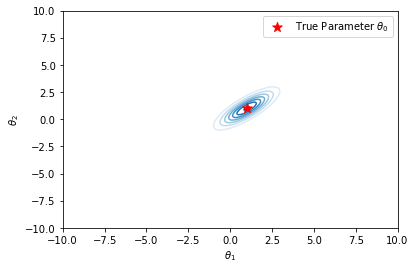

In [6]:
# Plot p(theta|mean(x_1,...,x_10)), x_i ~ simulator(theta_true)
theta_true = observation['theta_true']
x_obs_100 = torch.stack([simulator(theta_true) for i in range(100)])
true_posterior_100_pdf = data_gen.true_posterior_pdf(x_obs_100)
plt.scatter(theta_true[0], theta_true[1], marker="*", color="red", s=100, zorder=1, label=r'True Parameter $\theta_0$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plot_2d_pdf_on_grid(true_posterior_100_pdf, low_, high_)
plt.legend()
plt.show()

## Posterior Estimation: good vs. bad MAF

### Data Generation

In [5]:
# Simulate Data, create datasets
filename = PATH_EXPERIMENT+'datasets_big.pkl'

if os.path.exists(filename):
    datasets = torch.load(filename)
else:
    b_theta, b_x = data_gen.get_joint_data(B)
    b_prime_theta, b_prime_x = data_gen.get_joint_data(B_PRIME)
    b_double_prime_theta, b_double_prime_x = data_gen.get_joint_data(B_DOUBLE_PRIME)

    datasets = {
        "B": {'theta':b_theta, 'x':b_x},
        "B_prime": {'theta':b_prime_theta, 'x':b_prime_x},
        "B_double_prime": {'theta':b_double_prime_theta, 'x':b_double_prime_x},
    }
    torch.save(datasets, filename)


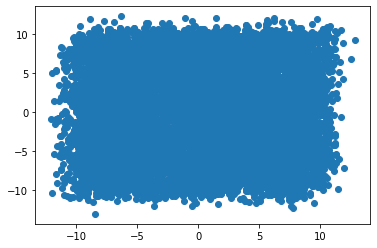

In [6]:
# Simulations Covered Space 
plt.scatter(datasets['B_prime']['x'][:,0], datasets['B_prime']['x'][:,1])
plt.show()

### Train Estimators: NPE (MAF)
In what follows, the estimator will try to approximate the posterior $p(\theta \mid x_0) = \mathcal{N}(x_0, \Sigma)$ with samples from the joint $(x_i, \theta_i) \sim p(x\mid \theta_i)p(\theta_i)$

In [7]:
# TRAIN/ LOAD TRAINED FLOWS
# Good MAF trained on X=(X_1,X_2)
filename_good = PATH_EXPERIMENT+'maf_good_bigDataset.pkl'

if os.path.exists(filename_good):
    # load flow 
    maf_good = torch.load(filename_good)
else: 
    # define flow
    maf_good = construct_maf(
        datasets['B']['theta'], hidden_features=50, context_features=2, standardize_transform=False
    )
    # train flow
    best_val_loss_good, epochs_good = train(
        maf_good,
        datasets['B']['theta'], # Theta
        context=datasets['B']['x'],  # X=(X_1,X_2)
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

    # save flow
    torch.save(maf_good, filename_good)

# Bad MAF trained on g(X) = X_1
filename_bad = PATH_EXPERIMENT+'maf_bad_bigDataset.pkl'

if os.path.exists(filename_bad):
    # load flow
    maf_bad = torch.load(filename_bad)
else: 
    # define flow 
    maf_bad = construct_maf(
        datasets['B']['theta'], hidden_features=50, context_features=1, standardize_transform=False
    )
    # train flow
    best_val_loss_bad, epochs_bad = train(
        maf_bad,
        datasets['B']['theta'], # Theta
        context=first_dim_only(datasets['B']['x']),  # g(X) = X_1
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

    # save flow
    torch.save(maf_bad, filename_bad)


### Plot densities

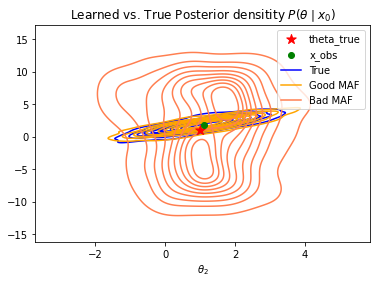

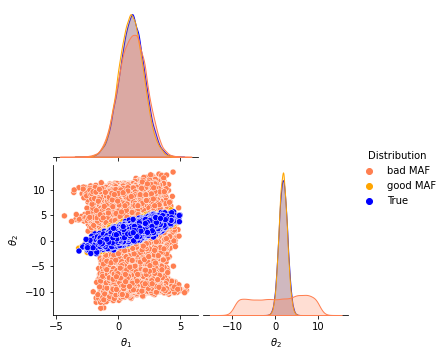

In [8]:
# Plot True vs. learned posteriors: P(theta | x_obs)
true_posterior = data_gen.true_posterior(x_obs)

flows = {
    "Good MAF": (maf_good, x_obs[:][None], "orange"),
    "Bad MAF": (maf_bad, first_dim_only(x_obs[:][None]), "coral"),
}

plt.scatter(
    theta_true[0],
    theta_true[1],
    marker="*",
    s=100,
    color="red",
    label="theta_true",
    zorder=3,
)
plt.scatter(x_obs[0], x_obs[1], color="green", label="x_obs", zorder=3)
plt.xlabel(r"$\theta_1$")
plt.xlabel(r"$\theta_2$")
plot_2d_pdf_contours(
    true_posterior,
    flows=flows,
    title=r"Learned vs. True Posterior densitity $P(\theta\mid x_0)$",
)

# Pairplot
import pandas as pd
import seaborn as sns
columns = [r"$\theta_1$", r"$\theta_2$"]

samples_true = true_posterior.sample((N_SAMPLES_POSTERIOR,)).numpy()
df_true = pd.DataFrame(samples_true, columns=columns)
df_true["Distribution"] = "True"

maf_samples_good = maf_good.sample(N_SAMPLES_POSTERIOR, context=x_obs[:][None])[0]
df_maf_good = pd.DataFrame(maf_samples_good.detach().numpy(), columns=columns)
df_maf_good["Distribution"] = "good MAF"

maf_samples_bad = maf_bad.sample(N_SAMPLES_POSTERIOR, context=first_dim_only(x_obs[:][None]))[0]
df_maf_bad = pd.DataFrame(maf_samples_bad.detach().numpy(), columns=columns)
df_maf_bad["Distribution"] = "bad MAF"

dfs = pd.concat([df_maf_bad, df_maf_good, df_true], ignore_index=True)

sns.pairplot(dfs, hue="Distribution", corner=True, palette={"True":"blue", "good MAF": "orange", "bad MAF": "coral"})
plt.show()


## Validation - Coverage Tests (MultiPIT)

### Global Coverage

#### PP-plots 

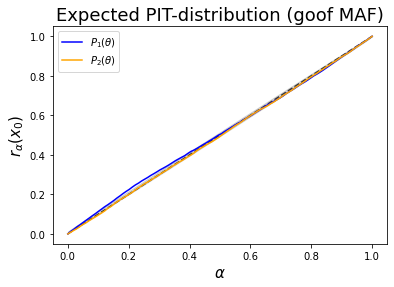

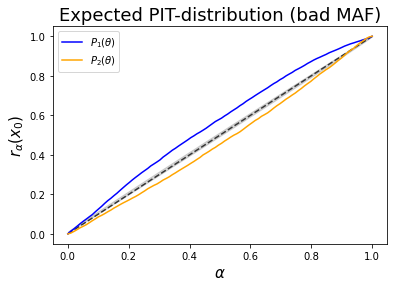

In [9]:
# PLOT EXPECTED PIT-DISTRIBUTION of the trained estimators
theta_test, x_test = datasets['B_prime']['theta'], datasets['B_prime']['x']

# Compute PIT-values of the flows 
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)
flow_joint_pit_values_good = multi_cde_pit_values(
    theta_test, x_test, maf_good, feature_transform=identity
)
# [PIT(Theta_i, X_i, maf_bad) = F_{Q_bad|X_i}(Theta_i)]
flow_joint_pit_values_bad = multi_cde_pit_values(
    theta_test, x_test, maf_bad, feature_transform=first_dim_only
)

# PP-plot of expected PIT-distribution for both flows
# alpha-quantiles = [P_X,Theta(Z < alpha)]

# Good MAF
PP_plot_1D(
    PIT_values=[flow_joint_pit_values_good[0], flow_joint_pit_values_good[1]],
    alphas=np.linspace(0, 1, 100),
    colors=["blue", "orange"],
    labels=[r"$P_1(\theta)$", r"$P_2(\theta)$"],
    title=r"Expected PIT-distribution (goof MAF)",
    confidence_int = True,
)

# Bad MAF
PP_plot_1D(
    PIT_values=[flow_joint_pit_values_bad[0], flow_joint_pit_values_bad[1]],
    alphas=np.linspace(0, 1, 100),
    colors=["blue", "orange"],
    labels=[r"$P_1(\theta)$", r"$P_2(\theta)$"],
    title=r"Expected PIT-distribution (bad MAF)",
    confidence_int = True,
)


#### Mutual independance: Correlation coefficient for MultiPIT-covariates

In [10]:
# good maf
pit_eval_good = {
        'P_1':maf_good._transform(theta_test, context = x_test)[0][:, 0].detach().numpy(),
        'P_2':maf_good._transform(theta_test, context = x_test)[0][:, 1].detach().numpy(),
    }
df_good = pd.DataFrame(pit_eval_good)
corr_12_good = df_good.corr()['P_1'][1]
df_good.corr()

,P_1,P_2
P_1,1.000000,0.010454
P_2,0.010454,1.000000


In [11]:
# bad maf
pit_eval_bad = {
        'P_1':maf_bad._transform(theta_test, context = first_dim_only(x_test))[0][:, 0].detach().numpy(),
        'P_2':maf_bad._transform(theta_test, context = first_dim_only(x_test))[0][:, 1].detach().numpy(),
    }
df_bad = pd.DataFrame(pit_eval_bad)
corr_12_bad = df_bad.corr()['P_1'][1]
df_bad.corr()

,P_1,P_2
P_1,1.000000,-0.003544
P_2,-0.003544,1.000000


In [12]:
# null hypothesis
from scipy.stats import norm

n_trials = 1000

corr_12_null = []
for t in range(n_trials):
    pit_eval_null = {
        'P_1': norm().rvs(B_PRIME),
        'P_2': norm().rvs(B_PRIME),
        'P_3': norm().rvs(B_PRIME),
    }
    df_null = pd.DataFrame(pit_eval_null)
    corr_12_null.append(df_null.corr()['P_1'][1])
np.mean(corr_12_null), np.quantile(corr_12_null, q=0.05/2), np.quantile(corr_12_null, q=1-0.05/2)

(-6.780368587799555e-05, -0.019331959185494928, 0.018849647486155995)

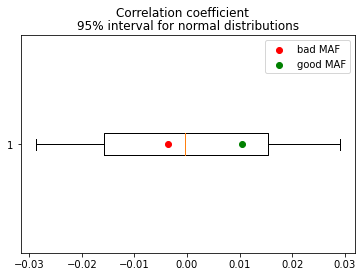

In [13]:
import matplotlib.cbook as cbook

data = corr_12_null
stats = cbook.boxplot_stats(data)[0]
stats['q1'] = np.quantile(data, 0.05)
stats['q3'] = np.quantile(data, 0.95)
stats['whislo'] = min(data)
stats['whishi'] = max(data)

fig, ax = plt.subplots(1, 1)
bp = ax.bxp([stats],widths=0.1, vert=False, showfliers=False,)
plt.scatter(corr_12_bad, 1, color='red', label='bad MAF')
plt.scatter(corr_12_good, 1, color='green', label='good MAF')
plt.legend()
plt.title('95% interval for normal distributions')
plt.suptitle('Correlation coefficient')
plt.show()


### Local Coverage
Estimate the local PIT values and the correlation coefficient via regression.

#### PP-plots

In [16]:
# TRAIN Local PIT regressors

from functools import partial
from diagnostics.multi_local_test import multi_local_pit_regression
from sklearn.neural_network import MLPClassifier
DEFAULT_CLF = MLPClassifier(alpha=0, max_iter=25000)
ALPHAS = np.linspace(0,0.99,100)
REG_METHOD = partial(
    localPIT_regression_baseline, alphas = ALPHAS
)
x_train = datasets['B_prime']['x'][:,:,None]

if os.path.exists(PATH_EXPERIMENT+'clfs_trained_bad.pkl'):
    clfs_bad = torch.load(PATH_EXPERIMENT+'clfs_trained_bad.pkl')
else:
    _, clfs_bad = multi_local_pit_regression(dim=2,pit_values_train=flow_joint_pit_values_bad,x_train=x_train, reg_method=REG_METHOD, classifier=DEFAULT_CLF)
    torch.save(clfs_bad, PATH_EXPERIMENT+'clfs_trained_bad.pkl')
if os.path.exists(PATH_EXPERIMENT+'clfs_trained_good.pkl'):
    clfs_good = torch.load(PATH_EXPERIMENT+'clfs_trained_good.pkl')
else:
    _, clfs_good = multi_local_pit_regression(dim=2,pit_values_train=flow_joint_pit_values_good,x_train=x_train, reg_method=REG_METHOD, classifier=DEFAULT_CLF)
    torch.save(clfs_good, PATH_EXPERIMENT+'clfs_trained_good.pkl')

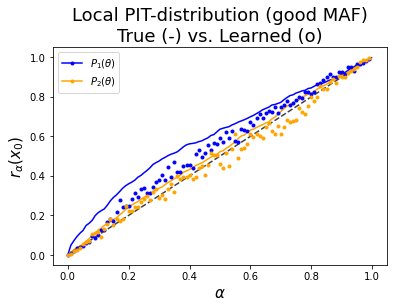

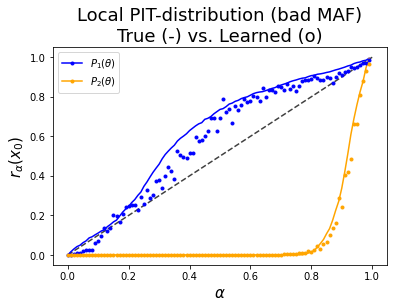

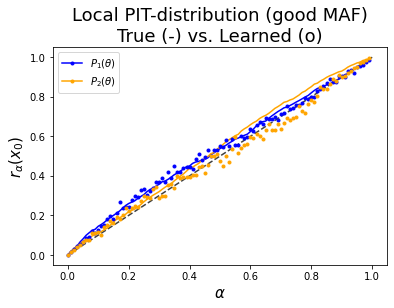

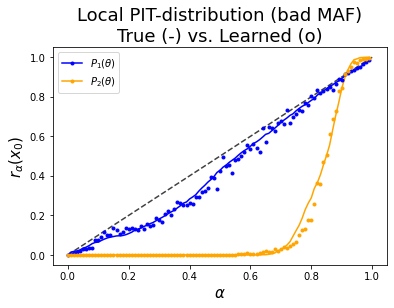

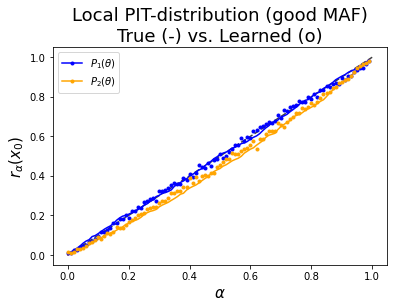

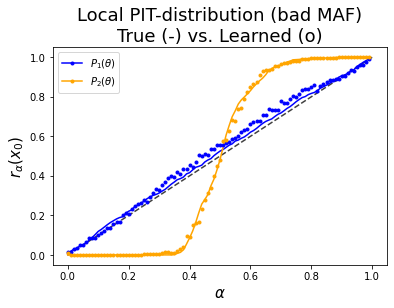

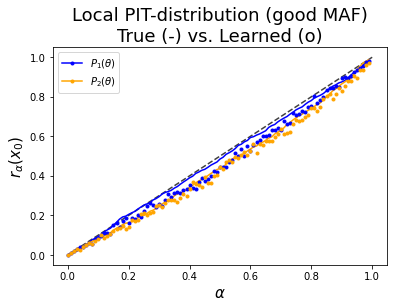

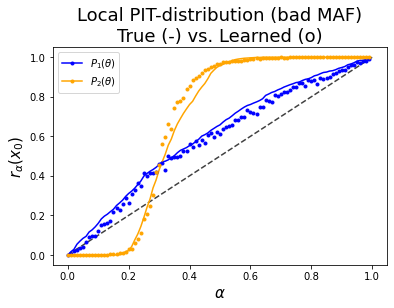

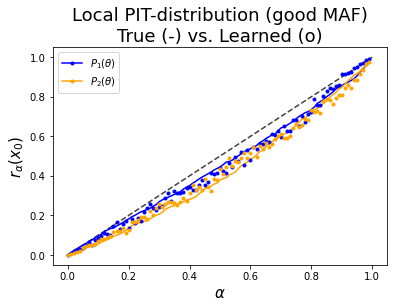

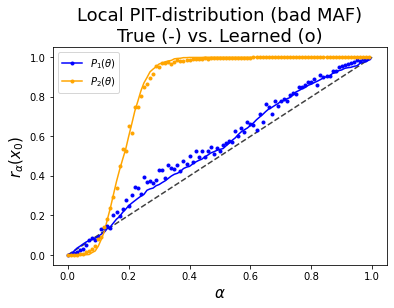

In [17]:
theta_true_list = [torch.FloatTensor([0, -8]), torch.FloatTensor([0, -6]), torch.FloatTensor([0, 0]), torch.FloatTensor([0, 6]), torch.FloatTensor([0, 8])]  # true parameters
x_obs_list = [simulator(theta_true) for theta_true in theta_true_list] # x_0 ~ simulator(theta_true)

for theta_true, x_obs in zip(theta_true_list, x_obs_list):
    # TRUE PIT-values of the flows [PIT(Theta_i, X_0, flow) = F_{Q|X_0}(Theta_i)
    true_posterior = data_gen.true_posterior(x_obs)
    theta_test_true = true_posterior.sample((1000,))  # samples of the true posterior
    # good maf
    flow_local_pit_values_good = multi_cde_pit_values(
        theta_test_true, x_obs.repeat((1000, 1)), maf_good, feature_transform=identity,
    )
    # bad maf
    flow_local_pit_values_bad = multi_cde_pit_values(
        theta_test_true,
        x_obs.repeat((1000, 1)),
        maf_bad,
        feature_transform=first_dim_only,
    )

    # Learned local PIT-values of the flows [PIT(Theta_i, X_0, flow) = F_{Q|X_0}(Theta_i)
    # good maf
    r_alpha_learned_good, _ = multi_local_pit_regression(
        dim=2,
        pit_values_train=flow_joint_pit_values_good,
        x_train=x_train,
        reg_method=REG_METHOD,
        classifier=DEFAULT_CLF,
        alphas_eval=ALPHAS,
        x_eval=x_obs[None, :, None],
        trained_clfs=clfs_good,
    )
    # bad maf
    r_alpha_learned_bad, _ = multi_local_pit_regression(
        dim=2,
        pit_values_train=flow_joint_pit_values_bad,
        x_train=x_train,
        reg_method=REG_METHOD,
        classifier=DEFAULT_CLF,
        alphas_eval=ALPHAS,
        x_eval=x_obs[None, :, None],
        trained_clfs=clfs_bad,
    )

    # PP-plot of local PIT-distribution for both flows
    # alpha-quantiles = [P_Theta|X_0(Z < alpha)]

    # Good MAF
    PP_plot_1D(
        PIT_values=[flow_local_pit_values_good[0], flow_local_pit_values_good[1]],
        # PIT_values=None,
        alphas=np.linspace(0, 0.99, 100),
        r_alpha_learned=[r_alpha_learned_good["dim_1"], r_alpha_learned_good["dim_2"]],
        colors=["blue", "orange"],
        colors_r_alpha=["blue", "orange"],
        labels=[r"$P_1(\theta)$", r"$P_2(\theta)$"],
        title=r"Local PIT-distribution (good MAF)" "\n" "True (-) vs. Learned (o)",
    )

    # Bad MAF
    PP_plot_1D(
        PIT_values=[flow_local_pit_values_bad[0], flow_local_pit_values_bad[1]],
        # PIT_values=None,
        alphas=np.linspace(0, 0.99, 100),
        r_alpha_learned=[r_alpha_learned_bad["dim_1"], r_alpha_learned_bad["dim_2"]],
        colors=["blue", "orange"],
        colors_r_alpha=["blue", "orange"],
        labels=[r"$P_1(\theta)$", r"$P_2(\theta)$"],
        title=r"Local PIT-distribution (bad MAF)" "\n" "True (-) vs. Learned (o)",
    )


#### Mutual independance: Correlation coefficient for MultiPIT-covariates

In [18]:
Z_1_good = maf_good._transform(theta_test, context=x_test)[0][:, 0].detach().numpy()
Z_2_good = maf_good._transform(theta_test, context=x_test)[0][:, 1].detach().numpy()
np.corrcoef(Z_1_good, Z_2_good)

array([[1.        , 0.01045379],
       [0.01045379, 1.        ]])

In [19]:
Z_1_null = []
Z_2_null = []
for k in range(1000):
    Z_1_null.append(torch.distributions.Normal(loc=0, scale=1).sample((10000,)))
    Z_2_null.append(torch.distributions.Normal(loc=0, scale=1).sample((10000,)))
[np.corrcoef(z_1, z_2) for z_1,z_2 in zip(Z_1_null, Z_2_null)][0]

array([[ 1.        , -0.00890794],
       [-0.00890794,  1.        ]])

In [20]:
# Prior
low_, high_ = -10, 10
prior = BoxUniform(
    low=torch.FloatTensor([low_, low_]), high=torch.FloatTensor([high_, high_])
)

theta_test_new = prior.sample((10000,))

Z_1_bad = maf_bad._transform(theta_test, context=first_dim_only(x_test))[0][:, 0].detach().numpy()
Z_2_bad = maf_bad._transform(theta_test, context=first_dim_only(x_test))[0][:, 1].detach().numpy()
np.corrcoef(Z_1_bad, Z_2_bad)

array([[ 1.        , -0.00354421],
       [-0.00354421,  1.        ]])

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

W_a_train = Z_1_good*Z_2_good

clf = MLPRegressor()
clf.fit(X=x_test, y=W_a_train)
result_good = clf.predict(x_obs_list[2][None,:])

clf_linreg = LinearRegression()
clf_linreg.fit(X=x_test, y=W_a_train)
result_good_linreg = clf_linreg.predict(x_obs_list[2][None,:])
print(result_good.item(), result_good_linreg.item())

-0.007205723178232537 0.004843107890337706


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

result_null = []
result_null_linreg = []
for k in range(1000):
    W_a_train = Z_1_null[k]*Z_2_null[k]
    clf = MLPRegressor()
    clf.fit(X=x_test, y=W_a_train)
    result_null.append(clf.predict(x_obs_list[2][None,:]))

    clf_linreg = LinearRegression()
    clf_linreg.fit(X=x_test, y=W_a_train)
    result_null_linreg.append(clf_linreg.predict(x_obs_list[2][None,:]))

print(np.mean(result_null), np.std(result_null))
print(np.mean(result_null_linreg), np.std(result_null_linreg))

0.0009745457265700754 0.05078877982196712
-6.083026e-07 0.010305288


In [23]:
# from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

W_a_train = Z_1_bad*Z_2_bad

clf = MLPRegressor(max_iter = 10000)
clf.fit(X=x_test, y=W_a_train)
result_bad = clf.predict(x_obs_list[2][None,:])

clf_linreg = LinearRegression()
clf_linreg.fit(X=x_test, y=W_a_train)
result_bad_linreg = clf_linreg.predict(x_obs_list[2][None,:])
print(result_bad.item(), result_bad_linreg.item())

-0.21265767530246504 -0.001062840223312378


/opt/miniconda3/envs/nflows/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


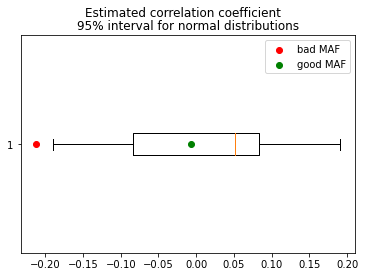

In [24]:
data = result_null
stats = cbook.boxplot_stats(data)[0]
stats['q1'] = np.quantile(data, 0.05)
stats['q3'] = np.quantile(data, 0.95)
stats['whislo'] = min(data)
stats['whishi'] = max(data)

fig, ax = plt.subplots(1, 1)
bp = ax.bxp([stats],widths=0.1, vert=False, showfliers=False,)
plt.scatter(result_bad, 1, color='red', label='bad MAF')
plt.scatter(result_good, 1, color='green', label='good MAF')
plt.legend()
plt.title('95% interval for normal distributions')
plt.suptitle('Estimated correlation coefficient')
plt.show()

## Confidence Regions: HPD vs. WALDO

### High Posterior Region: Confidence sets computed directly with the learned posterior

In [34]:
# 2-dimensional grid of (grid_sample_size X grid_sample_size) points
grid_sample_size = 100
param_grid_1d = np.linspace(-10, 10, num=grid_sample_size)
param_grid = np.transpose([np.tile(param_grid_1d, len(param_grid_1d)), np.repeat(param_grid_1d, len(param_grid_1d))])
grid_sample_size = grid_sample_size**2

# observations we whish to evaluate the posterior in
observations = [
    x_obs,  # generated via simulator and theta_true = [1,1]
    torch.FloatTensor([1, 1]),  # for reference = theta_true
    torch.FloatTensor([0, 0]),  # for comparison
    torch.FloatTensor([-1, -1]),  # for comparison
]

In [35]:
# Compute High Posterior Regions
hpd_regions_good = []
hpd_regions_bad = []
actual_confidence_levels_good = []
actual_confidence_levels_bad = []
for i in tqdm(range(len(observations))):
    x = observations[i][None].repeat(grid_sample_size,1)
    current_confidence_level_good, credible_region_good, _ = hpd_region(
        posterior=maf_good,
        prior=None,
        param_grid=torch.FloatTensor(param_grid.astype(np.float32)),
        x=x,
        confidence_level=CONFIDENCE_LEVEL,
        n_p_stars=100_000,
        tol=0.01,
    )
    current_confidence_level_bad, credible_region_bad, _ = hpd_region(
        posterior=maf_bad,
        prior=None,
        param_grid=torch.FloatTensor(param_grid.astype(np.float32)),
        x=first_dim_only(x),
        confidence_level=CONFIDENCE_LEVEL,
        n_p_stars=100_000,
        tol=0.01,
    )
    hpd_regions_good.append(credible_region_good)
    hpd_regions_bad.append(credible_region_bad)
    actual_confidence_levels_good.append(current_confidence_level_good)
    actual_confidence_levels_bad.append(current_confidence_level_bad)


100%|██████████| 4/4 [00:21<00:00,  5.47s/it]


## Calibrated Confidence Regions using WALDO

$\tau^{\text{Waldo}} = (\mathbb{E}[\mathbf{\theta}|\mathbf{x}] - \theta_0)^T \Sigma^{-1} (\mathbb{E}[\mathbf{\theta}|\mathbf{x}] - \theta_0)$

In [36]:
# Compute Waldo test statistics on data from joint distribution

# GOOD MAF
filename = PATH_EXPERIMENT + "posterior_stats_waldo_bigDataset.pkl"
if os.path.exists(filename):
    posterior_stats_waldo_good = torch.load(filename)
else:
    posterior_stats_waldo_good = []
    for i in tqdm(range(B_PRIME)):
        posterior_samples_qr = maf_good.sample(
            N_SAMPLES_POSTERIOR, context=datasets["B_prime"]["x"][i][None]
        )[0]
        posterior_mean = torch.mean(posterior_samples_qr, dim=0)
        posterior_var = torch.cov(torch.transpose(posterior_samples_qr, 0, 1))
        waldo_stats_i = waldo_stats(
            posterior_mean, posterior_var, param=datasets["B_prime"]["theta"][i, :]
        )
        posterior_stats_waldo_good.append(waldo_stats_i)
    del posterior_mean, posterior_var

    posterior_stats_waldo_good = np.array(posterior_stats_waldo_good)
    torch.save(posterior_stats_waldo_good, filename)

# BAD MAF
filename = PATH_EXPERIMENT + "posterior_stats_waldo_bad_bigDataset.pkl"
if os.path.exists(filename):
    posterior_stats_waldo_bad = torch.load(filename)
else:
    posterior_stats_waldo_bad = []
    for i in tqdm(range(B_PRIME)):
        posterior_samples_qr = maf_bad.sample(
            N_SAMPLES_POSTERIOR,
            context=first_dim_only(datasets["B_prime"]["x"][i][None]),
        )[0]
        posterior_mean = torch.mean(posterior_samples_qr, dim=0)
        posterior_var = torch.cov(torch.transpose(posterior_samples_qr, 0, 1))
        waldo_stats_i = waldo_stats(
            posterior_mean, posterior_var, param=datasets["B_prime"]["theta"][i, :]
        )
        posterior_stats_waldo_bad.append(waldo_stats_i)
    del posterior_mean, posterior_var

    posterior_stats_waldo_bad = np.array(posterior_stats_waldo_bad)
    torch.save(posterior_stats_waldo_bad, filename)

In [40]:
# Train quantile regression for critical value prediction

# GOOD MAF
filename = PATH_EXPERIMENT + "waldo_qr_nns.pkl"
if os.path.exists(filename):
    waldo_qr_nns_good = torch.load(filename)
else:
    learner_kwargs = {"epochs": 1000, "batch_size": 50}
    pytorch_kwargs = {"neur_shapes": (128, 128, 128)}
    qr_nn, predicted_cutoffs_nn = train_qr_algo(
        dim=2,
        alpha=CONFIDENCE_LEVEL,
        theta_mat=datasets["B_prime"]["theta"].numpy(),
        stats_mat=posterior_stats_waldo_good,
        learner_kwargs=learner_kwargs,
        pytorch_kwargs=pytorch_kwargs,
        prediction_grid=param_grid,
        nn_dropout=0.0,
    )

    waldo_qr_nns_good = {"qr_nn": qr_nn, "cutoffs_nn": predicted_cutoffs_nn}
    torch.save(waldo_qr_nns_good, "waldo_qr_nns.pkl")

# BAD MAF
filename = PATH_EXPERIMENT + "waldo_qr_nns_bad.pkl"
if os.path.exists(filename):
    waldo_qr_nns_bad = torch.load(filename)
else:
    learner_kwargs = {"epochs": 1000, "batch_size": 50}
    pytorch_kwargs = {"neur_shapes": (128, 128, 128)}
    qr_nn, predicted_cutoffs_nn = train_qr_algo(
        dim=2,
        alpha=CONFIDENCE_LEVEL,
        theta_mat=datasets["B_prime"]["theta"].numpy(),
        stats_mat=posterior_stats_waldo_bad,
        learner_kwargs=learner_kwargs,
        pytorch_kwargs=pytorch_kwargs,
        prediction_grid=param_grid,
        nn_dropout=0.0,
    )

    waldo_qr_nns_bad = {"qr_nn": qr_nn, "cutoffs_nn": predicted_cutoffs_nn}
    torch.save(waldo_qr_nns_bad, "waldo_qr_nns_bad.pkl")


In [41]:
# Compute calibrated confidence sets with waldo stats and critical values
confidence_sets_good = []
confidence_sets_bad = []
for i in tqdm(range(len(observations)), desc="Computing confidence sets"):
    # sample from learned posterior
    posterior_samples_obs_good = maf_good.sample(
        N_SAMPLES_POSTERIOR, context=observations[i][None]
    )[0]
    posterior_samples_obs_bad = maf_bad.sample(
        N_SAMPLES_POSTERIOR, context=first_dim_only(observations[i][None])
    )[0]
    confidence_sets_good.append(
        waldo_confidence_region(
            posterior_samples=posterior_samples_obs_good,
            critical_values=waldo_qr_nns_good["cutoffs_nn"],
            param_grid=param_grid,
            grid_sample_size=grid_sample_size,
        )
    )
    confidence_sets_bad.append(
        waldo_confidence_region(
            posterior_samples=posterior_samples_obs_bad,
            critical_values=waldo_qr_nns_bad["cutoffs_nn"],
            param_grid=param_grid,
            grid_sample_size=grid_sample_size,
        )
    )



Computing confidence sets: 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


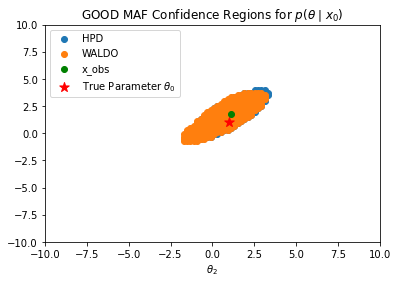

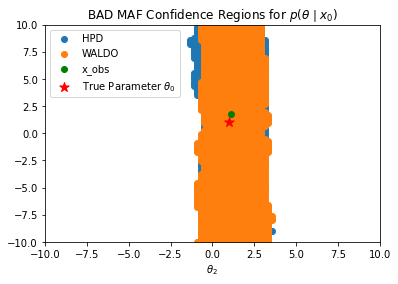

In [52]:
# Plot HPD vs WALDO Confidence Regions 

# GOOD MAF
plt.scatter(hpd_regions_good[0][:, 0], hpd_regions_good[0][:, 1], label='HPD')
plt.scatter(confidence_sets_good[0][:, 0], confidence_sets_good[0][:, 1], label='WALDO')
plt.scatter(x_obs[0], x_obs[1], color="green", label="x_obs", zorder=3)
plt.scatter(
    theta_true[0],
    theta_true[1],
    marker="*",
    color="red",
    s=100,
    zorder=1,
    label=r"True Parameter $\theta_0$",
)
plt.xlabel(r"$\theta_1$")
plt.xlabel(r"$\theta_2$")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.legend()
plt.title(r'GOOD MAF Confidence Regions for $p(\theta \mid x_0)$')
plt.show()

# BAD MAF
plt.scatter(hpd_regions_bad[0][:, 0], hpd_regions_bad[0][:, 1], label='HPD')
plt.scatter(confidence_sets_bad[0][:, 0], confidence_sets_bad[0][:, 1], label='WALDO')
plt.scatter(x_obs[0], x_obs[1], color="green", label="x_obs", zorder=3)
plt.scatter(
    theta_true[0],
    theta_true[1],
    marker="*",
    color="red",
    s=100,
    zorder=1,
    label=r"True Parameter $\theta_0$",
)
plt.xlabel(r"$\theta_1$")
plt.xlabel(r"$\theta_2$")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.legend()
plt.title(r'BAD MAF Confidence Regions for $p(\theta \mid x_0)$')
plt.show()


In [13]:
x_obs[:][None].shape

torch.Size([1, 2])